In [69]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.stats import linregress
from matplotlib import pyplot as plt

In [70]:
d = pd.read_csv('../tables/merged_observed.csv')

In [71]:
d = d[np.logical_not((d['Ice_Flag_2DS']==1) | (d['ED-liquid_2DS']>=60E-6) | (d['LWC_FCDP']>0.005) | (d['ams_tot'] < 0.04) | (d['N_CCN_stdPT'] < 50))].reset_index(drop=True)
d = d[(d['Org_Ave_IsoK_STP']>=0) & (d['SO4_Ave_IsoK_STP']>=0) & (d['NO3_Ave_IsoK_STP']>=0) & (d['NH4_Ave_IsoK_STP']>=0) & (d['Chl_Ave_IsoK_STP']>=0)].reset_index(drop=True)

In [72]:
def calc_k(data, org_k, so4_k, no3_k, nh4_k, chl_k):
    d = data.copy()
    d['k'] = np.nan
    d['Org_vc'] = d['Org_Ave_IsoK_STP'] / 1000
    d['SO4_vc'] = d['SO4_Ave_IsoK_STP'] / 1770
    d['NO3_vc'] = d['NO3_Ave_IsoK_STP'] / 1770
    d['NH4_vc'] = d['NH4_Ave_IsoK_STP'] / 1770
    d['Chl_vc'] = d['Chl_Ave_IsoK_STP'] / 2200

    d['ams_tot_vc'] = d['Org_vc']+d['SO4_vc']+d['NO3_vc']+d['NH4_vc']+d['Chl_vc']

    d['k'] = org_k*d['Org_vc']/d['ams_tot_vc'] + so4_k*d['SO4_vc']/d['ams_tot_vc'] + no3_k*d['NO3_vc']/d['ams_tot_vc'] + nh4_k*d['NH4_vc']/d['ams_tot_vc'] + chl_k*d['Chl_vc']/d['ams_tot_vc']

    return d

In [73]:
# Define an objective function to minimize
def objective(params, d):
    org_k, so4_k, no3_k, nh4_k, chl_k = params
    k_predicted = calc_k(d, org_k, so4_k, no3_k, nh4_k, chl_k)['k']
    # Calculate the sum of squared differences
    return np.sum((d['k_obs'] - k_predicted)**2)

# Define initial guesses for the kappas
initial_guess = [0.1, 0.1, 0.1, 0.1, 0.1]

d_sub = d[(d['k_obs']>0.12)&(d['k_obs']<1)]

# Perform the optimization
result = minimize(objective, initial_guess, args=(d_sub), method='Nelder-Mead')

# Extract the optimized kappa values
org_k_opt, so4_k_opt, no3_k_opt, nh4_k_opt, chl_k_opt = result.x

print("Optimized kappa values:")
print("org_k:", org_k_opt)
print("so4_k:", so4_k_opt)
print("no3_k:", no3_k_opt)
print("nh4_k:", nh4_k_opt)
print("chl_k:", chl_k_opt)

Optimized kappa values:
org_k: 0.23748308529773615
so4_k: 0.17298634288499148
no3_k: 0.1934613742332681
nh4_k: 0.044440511768564936
chl_k: 2.395199807934449


In [74]:
result.x

array([0.23748309, 0.17298634, 0.19346137, 0.04444051, 2.39519981])

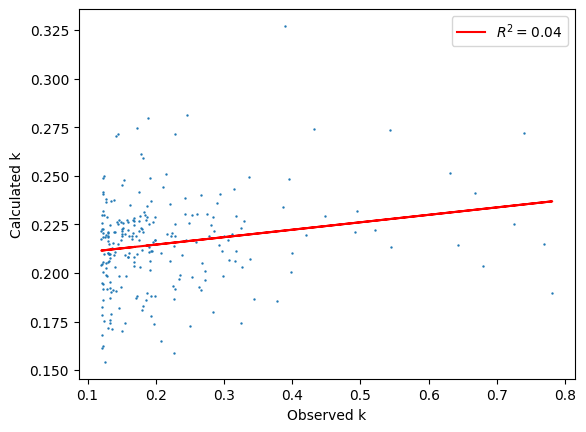

In [75]:
d_sub = calc_k(d_sub, *result.x)
# Fit a line to the data
slope, intercept, r_value, _, _ = linregress(d_sub['k_obs'], d_sub['k'])
r_squared = r_value ** 2

# Plot the scatter and fitted line
plt.scatter(d_sub['k_obs'], d_sub['k'], s=0.5)
plt.plot(d_sub['k_obs'], slope * d_sub['k_obs'] + intercept, color="red", label=f"$R^2 = {r_squared:.2f}$")
#plt.xlim([0, 0.1])
#plt.ylim([0, 0.1])
plt.xlabel("Observed k")
plt.ylabel("Calculated k")
plt.legend()
plt.show()

In [76]:
d_sub

,Unnamed: 0,index,Time_Mid,SMPS_Bin02,SMPS_Bin03,SMPS_Bin04,SMPS_Bin05,SMPS_Bin06,SMPS_Bin07,SMPS_Bin08,...,k_obs,D_c,CCN_n_pred,k,Org_vc,SO4_vc,NO3_vc,NH4_vc,Chl_vc,ams_tot_vc
32,87,87,2020-02-14 18:34:31.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.186917,131.225927,745.799508,0.234580,0.001044,0.000406,0.000278,0.000191,0.000032,0.001951
84,189,189,2020-02-15 17:23:22.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.248355,111.306715,671.904113,0.225564,0.000828,0.000313,0.000067,0.000023,0.000006,0.001236
88,217,217,2020-02-15 17:51:22.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.131573,97.309516,969.852195,0.206137,0.000845,0.000450,0.000042,0.000277,0.000015,0.001631
99,264,264,2020-02-15 18:44:22.500,0.0,0.0,0.0,0.00,0.0,535.96,0.00,...,0.167872,133.522096,332.848658,0.207989,0.000939,0.000440,0.000034,0.000115,0.000003,0.001531
100,266,266,2020-02-15 18:46:22.500,0.0,0.0,0.0,0.00,0.0,0.00,0.00,...,0.128667,126.070406,402.697930,0.228777,0.000418,0.000464,0.000065,0.000038,0.000015,0.000999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8871,25184,25184,2022-06-17 16:30:00.500,0.0,0.0,0.0,0.00,0.0,548.95,1545.81,...,0.769232,50.732398,329.499820,0.215023,0.000431,0.000585,0.000017,0.000247,0.000026,0.001307
8880,25220,25220,2022-06-18 12:19:57.500,0.0,0.0,0.0,0.00,0.0,0.00,0.00,...,0.266742,72.103955,231.800008,0.191242,0.000453,0.000494,0.000047,0.000157,0.000005,0.001156
8892,25254,25254,2022-06-18 13:15:57.500,NaN,0.0,0.0,0.00,0.0,625.90,623.56,...,0.258254,72.879887,1070.000252,0.216141,0.003701,0.001245,0.000147,0.000543,0.000033,0.005669
8932,25306,25306,2022-06-18 14:19:57.500,NaN,0.0,0.0,0.00,0.0,0.00,0.00,...,0.280475,70.915282,1114.000140,0.224829,0.002407,0.000422,0.000050,0.000088,0.000004,0.002971
